In [ ]:
def yolo_model_image(video_dir):   
    for video_file in os.listdir(video_dir):
        if video_file.endswith('.jpg'):
            print('Processing video:', video_file)
            cap = cv2.VideoCapture(os.path.join(video_dir, video_file))
            i = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                _, box, conf = face.face_detection(frame_arr=frame, frame_status=True, model='tiny')
                for (x, y, w, h) in box:
                    roi_color = frame[y:y+h, x:x+w]
                    print("[INFO] Object found. Saving locally.")
                    try:
                        cv2.imwrite(os.path.join(output_dir, f'{video_file}_frame{i}_face.jpg'), roi_color)
                    except:
                        pass
                    i += 1
                # display output frames
                # output_frame = face.show_output(img=frame, face_box=box, frame_status=True)
                # cv2.imshow('frame', output_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            cap.release()
            cv2.destroyAllWindows()

In [80]:
from yoloface import face_analysis
import cv2 as cv
import matplotlib.pyplot as plt
import os

yolov3-tiny_face.weights:: status : file already exists
yolov3_tiny_face.cfg:: status : file already exists
face_detection.weights:: status : file already exists
face_detection.cfg:: status : file already exists


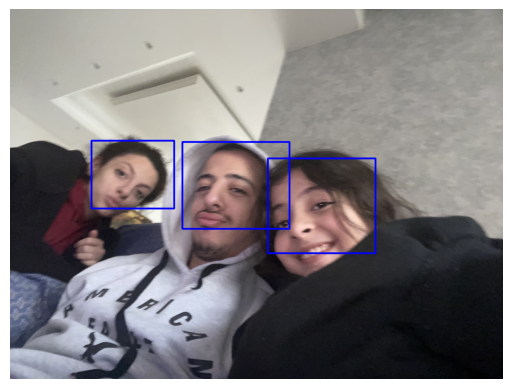

In [81]:
def image_face_detector(img_path):
    frame=cv.imread(img_path)
    frame_copy=frame.copy()
    face=face_analysis()##############
    _, box,_ =face.face_detection(frame_arr=frame, frame_status=True, model='tiny')
    
    i=1
    for (x, y, w, h) in box:
        cv.rectangle(frame_copy,(x,y),(x+w,y+h),(255, 0, 0),5)
        cv.imwrite(f"detected_faces/{os.path.basename(img_path)}_face{i}.jpg",frame[y:y+h, x:x+w])
        i=i+1
        
    return frame_copy[:,:,::-1]

new=image_face_detector("/Users/yazeed/python_projects/grad_final/Image 2.jpeg")

plt.imshow(new)
plt.axis(False)
plt.show()

In [ ]:
def yolo_model_video(video_dir):   
    # Define the path to the folder for highest score images
    high_score_folder = os.path.join(faces_dir, 'highest_score_images')
    if not os.path.exists(high_score_folder):
        os.mkdir(high_score_folder)

    for video_file in os.listdir(video_dir):
        if not video_file.endswith('.mp4'):
            continue
            
        print('Processing video:', video_file)
        
        # Reset variables
        confidences = []
        images = []
        orig_images = []
        
        video_folder = os.path.join(faces_dir, f'{os.path.splitext(video_file)[0]}')
        if not os.path.exists(video_folder):
            os.mkdir(video_folder)
        cap = cv2.VideoCapture(os.path.join(video_dir, video_file))
        i = 0
        while True: 
            ret, frame = cap.read()
            if not ret:
                break
            _, box, conf = face.face_detection(frame_arr=frame, frame_status=True, model='tiny')
            for (x, y, w, h) in box:
                roi_color = frame[y:y+h, x:x+w]
                print("[INFO] Object found. Saving locally.")
                try:
                    cv2.imwrite(os.path.join(video_folder, f'{os.path.splitext(video_file)[0]}_frame{i}_face.jpg'), roi_color)
                    confidences.append(conf)  # Append the confidence value to the list
                except:
                    pass
                i += 1
            # display output frames
            output_frame = face.show_output(img=frame, face_box=box, frame_status=True)
            #cv2.imshow('frame', output_frame)
            plt.imshow(output_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()

        # Load all images from the 'faces' folder and preprocess them for ResNet50
        for filename in os.listdir(video_folder):
            img = cv2.imread(os.path.join(video_folder, filename))
            orig_images.append(img)
            try:
                img = cv2.resize(img, (224, 224))
            except:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_input(img)
            images.append(img)

        # Convert the list of images to a 4D numpy array
        X = np.array(images)

        # Apply ResNet50 feature extraction to the image data
        model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        features = model.predict(X)

        # Flatten the features into a 2D numpy array
        features = features.reshape(features.shape[0], -1)

        # Calculate cosine similarity matrix
        cos_sim = cosine_similarity(features)

        # Apply hierarchical clustering to the feature data
        hierarchical = AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=0.8)
        hierarchical.fit(cos_sim)

        # Get the labels assigned to each image
        labels = hierarchical.labels_.astype(int)

        # Process images from each cluster
        for i in range(np.max(labels) + 1):
            print(f'Processing images in cluster {i}...')
            # Get the indices of the images in this cluster
            indices = np.where(labels == i)[0]
            # Calculate the score for each image in this cluster
            scores = []
            for idx in indices:
                img = orig_images[idx]
                brightness_score = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).mean()
                contrast_score = np.std(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
                sharpness_score = cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
                confidence = confidences[idx]  # get the confidence value for this image
                score = (0.5 * brightness_score + 0.3 * contrast_score + 0.2 * sharpness_score) * confidence[0]
                scores.append(score)
            # Save the image with the highest score to the appropriate folder
            highest_score_idx = np.argmax(scores)
            highest_score_img = orig_images[indices[highest_score_idx]]
            filename = os.path.join(high_score_folder, f'score_{scores[highest_score_idx]:.4f}_{indices[highest_score_idx]}.jpg')
            cv2.imwrite(filename, highest_score_img)

In [82]:
import cv2

In [83]:
cv2.VideoCapture()

< cv2.VideoCapture 0x1689a49b0>

In [84]:
cap = cv2.VideoCapture('output.mp4')

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        plt.imshow(frame)
        
cap.release()


Error opening video stream or file


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x12665a3c0] moov atom not found
OpenCV: Couldn't read video stream from file "output.mp4"


In [2]:
import cv2
  
   
# Create an object to read 
# from camera
video = cv2.VideoCapture("uploaded_videos/cam1_1.mp4")
   
# We need to check if camera
# is opened previously or not
if (video.isOpened() == False): 
    print("Error reading video file")
  
# We need to set resolutions.
# so, convert them from float to integer.
frame_width = int(video.get(3))
frame_height = int(video.get(4))
   
size = (frame_width, frame_height)
   
# Below VideoWriter object will create
# a frame of above defined The output 
# is stored in 'filename.avi' file.
result = cv2.VideoWriter('filename.mp4', 
                         cv2.VideoWriter_fourcc(*'mp4v'),
                         10, size)
    
while(True):
    ret, frame = video.read()
  
    if ret == True: 
  
        # Write the frame into the
        # file 'filename.avi'
        result.write(frame)
  
        # Display the frame
        # saved in the file
  
        # Press S on keyboard 
        # to stop the process
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break
  
    # Break the loop
    else:
        break
  
# When everything done, release 
# the video capture and video 
# write objects
video.release()
result.release()
    
# Closes all the frames   
print("The video was successfully saved")

The video was successfully saved


In [9]:
import matplotlib.pyplot as plt
import cv2
video = cv2.VideoCapture("output.mp4")

while(True):
    ret, frame = video.read()
  
    if ret == True: 
        cv2.imshow("hi",frame)
        if (cv2.waitKey(1) & 0xFF) == ord('q'): # Hit `q` to exit
            break
    else:
        break

video.release()

In [10]:
import subprocess

: 

In [2]:
import matplotlib.pyplot as plt
import cv2
video = cv2.VideoCapture("/Users/yazeed/python_projects/grad_final/uploaded_videos/cam1_1.mp4")

In [6]:
int(video.get(cv2.CAP_PROP_FRAME_COUNT))

723

In [1]:
import numpy as np
import cv2

cap = cv2.VideoCapture('uploaded_videos/cam1_1.mp4')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (int(cap.get(3)),int(cap.get(4))))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:

        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        lower_green = np.array([40, 60, 60]) 
        upper_green = np.array([80, 255, 255])

        mask = cv2.inRange(hsv, lower_green, upper_green)
        mask = cv2.GaussianBlur(mask, (7, 7), 0)
        res = cv2.bitwise_and(frame, frame, mask=mask)
        out.write(res)
        if (cv2.waitKey(1) & 0xFF) == ord('q'): # Hit `q` to exit
            break
    else:
        break

# Release everything if job is finished
out.release()
cap.release()


: 

In [ ]:
cv2.empty

In [ ]:
cv2.CAP_PROP_FPS